# Todas as formas de **seleção** e **cruzamento** estão implementadas, apenas deve-se mudar no código da iteração principal, com os paramentros ***(popToBeCloned, nClones)*** para a seleção, e ***(point1, point2)*** para os de cruzamento :)

#import

In [ ]:
pip install ypstruct

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ypstruct import structure

from functools import partial
from operator import attrgetter

#code

In [ ]:
#Sphere Function
def sphere(x):
  return sum(x**2)

In [ ]:
''' Selection '''

# Roulette Whell of Selection
def selRoulette(popToBeCloned, nClones):
    fit_attr="fitness"
    s_inds = sorted(popToBeCloned, key=attrgetter(fit_attr), reverse=True)
    sum_fits = sum(getattr(ind, fit_attr).values[0] for ind in popToBeCloned)
    chosen = []
    for i in np.xrange(nClones):
        u = np.random.random() * sum_fits
        sum_ = 0
        for ind in s_inds:
            sum_ += getattr(ind, fit_attr).values[0]
            if sum_ > u:
                chosen.append(ind)
                break

    return chosen

# Truncation selection
def truncation(popToBeCloned, nClones):
    newPop = []
    sorted_fitness = sorted(popToBeCloned, key=lambda x: x.fitness)
    for i in range(0, len(popToBeCloned)):
        r = np.random.randint((1 - nClones) * len(popToBeCloned), len(popToBeCloned))
        newPop.append(sorted_fitness[r])
    return sorted_fitness

# Stochastic Universal Sampling
def SUS(popToBeCloned, nClones):
    newPop = []
    sum = 0
    j = 1
    ptr = np.random.uniform(0, 1)
    for i in range(0, len(popToBeCloned)):
        sum = sum + nClones[i]
        while (sum > ptr):
            newPop.append(popToBeCloned[i])
            j = j + 1
            ptr = ptr + 1
    return newPop

# Tournament Selection
def tournament(popToBeCloned, nClones):
    newPop = []
    best = []
    for i in range(0, len(popToBeCloned)):
        for j in range(0, nClones):
            k = np.random.randint(0, len(popToBeCloned))
            best.append(popToBeCloned[k])
        sorted_fitness = sorted(best, key=lambda x: x.fitness)
        newPop.append(sorted_fitness[len(best) - 1])
    return newPop


In [ ]:
''' Crossover '''

# 1 point crossover 
def onepointC(point1, point2):
    size = min(len(point1), len(point2))
    cxpoint = np.random.randint(1, size - 1)
    point1[cxpoint:], point2[cxpoint:] = point2[cxpoint:], point1[cxpoint:]

    return point1, point2 

# 2 point crossover
def twopointC(point1, point2):
    size = min(len(point1), len(point2))
    cxpoint1 = np.random.randint(1, size)
    cxpoint2 = np.random.randint(1, size - 1)
    if cxpoint2 >= cxpoint1:
        cxpoint2 += 1
    else:  # Swap the two cx points
        cxpoint1, cxpoint2 = cxpoint2, cxpoint1

    point1[cxpoint1:cxpoint2], point2[cxpoint1:cxpoint2] \
        = point2[cxpoint1:cxpoint2], point1[cxpoint1:cxpoint2]

    return point1, point2

In [ ]:
''' Params '''
#Antigen
antigen = structure()
antigen.affinity_function = sphere
antigen.nvar = 5
antigen.varmin = [-10, -10, -1, -5,  4]
antigen.varmax = [ 10,  10,  1,  5, 10]

#Clonalg
clonalg = structure()
clonalg.popsize = 20
clonalg.maxit = 100
clonalg.nToBeCloned = clonalg.popsize//2
clonalg.nClones = 2
clonalg.hypermutationRate = 0.5
clonalg.hypermutationIntensity = 0.05

empty_antibody = structure()
empty_antibody.receptors = None
empty_antibody.affinity = None

In [ ]:
''' Mutation '''
def hypermutation(x, hypermutationRate, hypermutationIntensity):
  y = x.deepcopy()
  flag = np.random.rand(*x.receptors.shape) <= hypermutationRate
  indices = np.argwhere(flag)

  maximum = np.array(antigen.varmax)[indices]
  minimum = np.array(antigen.varmin)[indices]
  scale = maximum - minimum
  full_scale = hypermutationIntensity * scale
  
  y.receptors[indices] += 2 * (-0.5 + np.random.rand(*indices.shape)) * full_scale
  return y

def hypermutation_optimized(x, hypermutationRate, full_scale):
  y = x.deepcopy()
  flag = np.random.rand(*x.receptors.shape) <= hypermutationRate
  indices = np.argwhere(flag)
  
  y.receptors[indices] += 2 * (-0.5 + np.random.rand(*indices.shape)) * full_scale[indices]
  return y

''' Bounds '''
def apply_bounds(x, varmin, varmax):
  x.receptors = np.maximum(x.receptors, varmin)
  x.receptors = np.minimum(x.receptors, varmax)


best = empty_antibody.deepcopy()
best.affinity = np.inf

#Initialize Antibody Population - Steps 1 and 2
pop = empty_antibody.repeat(clonalg.popsize)
for i in range(clonalg.popsize):
  pop[i].receptors = np.random.uniform(antigen.varmin, antigen.varmax, antigen.nvar)
  pop[i].affinity = antigen.affinity_function(pop[i].receptors)
  if pop[i].affinity < best.affinity:
    best = pop[i]
  
best_affinity_per_iteration = np.empty(clonalg.maxit)

#pre calculate the full scale once
maximum = np.array(antigen.varmax)
minimum = np.array(antigen.varmin)
scale = maximum - minimum


In [ ]:
#Main loop of the algorithm

for iteration in range(clonalg.maxit):
  
  #Select the antibodies to be cloned - Step 3
  pop = sorted(pop, key=lambda x: x.affinity)
  popToBeCloned = pop[0:clonalg.nToBeCloned]

  #Generate clone population - Step 4
  clonePop = []

  for i in range(clonalg.nToBeCloned):
    clonePop += popToBeCloned[i].repeat(clonalg.nClones)

  if iteration <= (3*clonalg.maxit//2):
    full_scale = clonalg.hypermutationIntensity * scale
  else:
    full_scale = clonalg.hypermutationIntensity/20 * scale


  #Apply Hypermutation - Step 5 and Calculate Affinity - Step 6
  for i in range(clonalg.nClones * clonalg.nToBeCloned):
    clonePop[i] = hypermutation_optimized(clonePop[i], clonalg.hypermutationRate, full_scale)
    apply_bounds(clonePop[i], antigen.varmin, antigen.varmax)
    clonePop[i].affinity = antigen.affinity_function(clonePop[i].receptors)
  
  #Aggregate Antibodies and clones populations - Step 8 and Select the next Antibody population - Step 7
  unitedPop = pop + clonePop
  unitedPop = sorted(unitedPop, key=lambda x: x.affinity)
  pop = unitedPop[0:clonalg.popsize]

  #store the best affinity of the current iteration
  best_affinity_per_iteration[iteration] = pop[0].affinity
  #store the best solution
  if pop[0].affinity < best.affinity:
    best = pop[0]

#output

struct({'receptors': array([ 9.67660125e-03, -3.74715776e-03, -4.20264059e-04, -4.49223205e-03,
        4.00000000e+00]), 'affinity': 16.00012803457379})


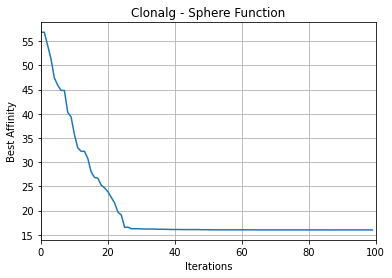

In [ ]:
#Best solution
print(best)

#Plot of the best solution per iteration
plt.plot(best_affinity_per_iteration)
plt.xlim(0, clonalg.maxit)
plt.xlabel('Iterations')
plt.ylabel('Best Affinity')
plt.title('Clonalg - Sphere Function')
plt.grid(True)
plt.show()